<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP (Part 3)

### Contents:
- Modeling
- Conclusion (Summary Table)
- Business Recommendations
- Further Analysis

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score,f1_score, roc_auc_score, plot_roc_curve
from sklearn import metrics

In [2]:
df = pd.read_csv('./final_nlp.csv')

In [3]:
df.head()

,subreddit,content
0,0,ankle swelling recently signed day pas local h...
1,0,cork mat better regular mat find get better wo...
2,0,found new studio moved henderson nv ago studio...
3,0,started going class sure get kind post frequen...
4,0,long take get good struggling core strength mo...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1982 non-null   int64 
 1   content    1982 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [5]:
df.isnull().sum()

subreddit    0
content      0
dtype: int64

In [6]:
df.dtypes

subreddit     int64
content      object
dtype: object

### Modeling

In [7]:
#Define Feature Matrix and Target Vector.

y = df['subreddit']
X = df['content']

In [8]:
#Create a function to print scores & best param 
#Based on model 

def print_score_param(model):
    
    print("======== All Score ========")
    #1.Best score
    print(f"Best Score: {model.best_score_}")
    
    #2.Train score
    print(f"Train Score: {model.score(X_train, y_train)}")
    
    #3.Test score
    print(f"Test Score: {model.score(X_test, y_test)}\n")
    
    print("======== Best Params ========")
    #4.Best params
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')

In [9]:
#Create a function to print performance measures
#Performance measures like Accuracy, Specificity, Sensitivity, Precision
#Based on model

def performance_measures(model, X_test, y_test):
    #1.Prediction
    preds = model.predict(X_test)
    
    #2.Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    #3.Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', 
                          values_format='d', display_labels=['yoga', 'pilates']);
    
    print("======== Performance ========")
    #4. Accuracy
    #accuracy = (tn + tp) / (tn + fp + fn + tp) 
    accuracy = accuracy_score(y_test, preds)
    print(f'Accuracy: {round(accuracy, 4)}')
    
    #5.Specificity
    specificity = tn / (tn + fp)
    print(f'Specificity: {round(specificity, 4)}')
    
    #6.Sensitivity
    #sensitivity = tp / (tp + fn)
    sensitivity = recall_score(y_test, preds)
    print(f'Sensitivity: {round(sensitivity, 4)}')
    
    #7.Precision
    # precision = tp / (tp + fp)
    precision = precision_score(y_test, preds)
    print(f'Precision: {round(precision, 4)}')
    
    #8.f1 score
    #f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, preds)
    print(f'F1 score: {round(f1score, 4)}')
    
    #9.roc_auc score
    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC AUC Score: {round(roc_auc, 4)}')

#### Baseline Accuracy

In [10]:
y.value_counts(normalize=True)

1    0.502523
0    0.497477
Name: subreddit, dtype: float64

In [11]:
#Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [12]:
#Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer(analyzer = "word",
                             max_features = 10_000,
                            ngram_range=(1,2))

In [13]:
cvec.fit(X_train)

CountVectorizer(max_features=10000, ngram_range=(1, 2))

In [14]:
#Transform
X_train_cvec = cvec.transform(X_train)

In [15]:
X_train_cvec.shape

(1486, 10000)

#### Model Pipeline - CountVectorizer & Logistic Regression

Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. For binary classification, a probability less than 0.5 will predict 0 while a probability greater than 0 will predict 1.

In [16]:
#Let's set a pipeline up with two stages:
#1. CountVectorizer (transformer)
#2. Logistic Regression (estimator)

pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [17]:
#Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [18]:
#Hyper parameters
#Note that our shape from standard/default CountVectorizer is (1486, 10_000)
pipe_cvec_lr_params = {
    'cvec__max_features': [2_500, 5_000, 10_000], #only top n words from the dataset
    'cvec__min_df': [2, 3, 4], # word must occur at least 2/4 from the dataset
    'cvec__max_df': [.85, .9], #ignore words that occur 
    'cvec__ngram_range': [(1,1), (1,2)], #1-gram and 2-gram
}

In [19]:
#Instantiate GridSearchCV.

gs_cvec_lr = GridSearchCV(pipe_cvec_lr, #Object for optimizin
                          param_grid=pipe_cvec_lr_params, #Parameters values to search
                          cv=5, #5-fold cross-validation.
                          n_jobs=-1) 

In [20]:
#Fit GridSearch to training data.
gs_cvec_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [2500, 5000, 10000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [21]:
#Print the scores and best param
print_score_param(gs_cvec_lr)


======== All Score ========
Best Score: 0.8431948116511876
Train Score: 0.9993270524899058
Test Score: 0.8004032258064516

======== Best Params ========
cvec__max_df: 0.85
cvec__max_features: 5000
cvec__min_df: 3
cvec__ngram_range: (1, 2)


======== Performance ========
Accuracy: 0.8004
Specificity: 0.7976
Sensitivity: 0.8032
Precision: 0.8
F1 score: 0.8016
ROC AUC Score: 0.8004


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


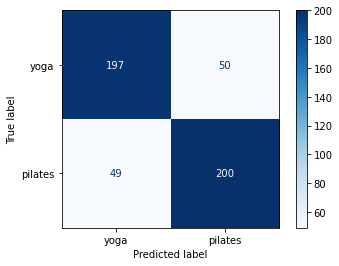

In [22]:
#Print the performance metrics
performance_measures(gs_cvec_lr, X_test, y_test)

In [23]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_cvec_lr = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_cvec_lr.predict_proba(X_test)[:,1]})

pred_cvec_lr.head()

,true_values,pred_probs
1060,1,0.992381
460,0,0.202956
1128,1,0.905845
1102,1,0.992395
683,0,0.358011


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


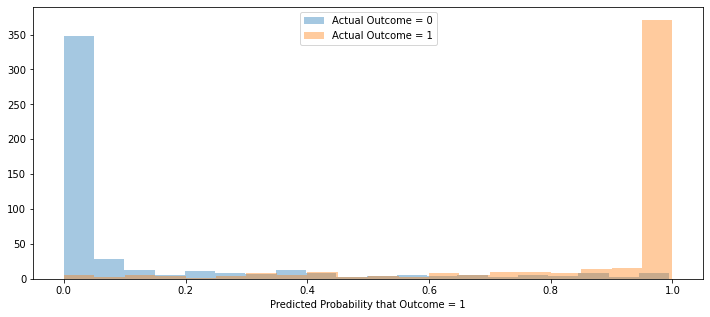

In [24]:
plt.figure(figsize = (12, 5))

#plot distributions of predicted probabilities by actual values
for group in pred_cvec_lr.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


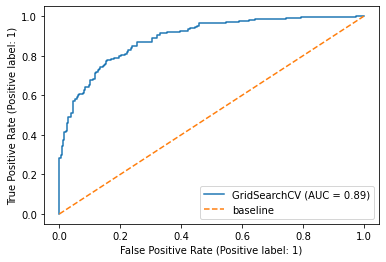

In [25]:
plot_roc_curve(gs_cvec_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [26]:
roc_auc_score(y_test, gs_cvec_lr.predict_proba(X_test)[:,1])

0.8911922995626229

#### Model Pipeline - TfidfVectorizer & Logistic Regression

In [27]:
#Let's set a pipeline up with two stages:
#1. TfidfVectorizer (transformer)
#2. Logistic Regression (estimator)
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [28]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify = y)

In [29]:
pipe_tvec_lr_params = {
    'tvec__max_features': [2_500, 5_000, 10_000], 
    'tvec__min_df': [2, 3, 4], 
    'tvec__max_df': [.8, .85, .9], 
    'tvec__ngram_range': [(1,1), (1,2), (2,2)] 
}

In [30]:
#Instantiate GridSearchCV.
gs_tvec_lr = GridSearchCV(pipe_tvec_lr,
                         param_grid = pipe_tvec_lr_params,
                         cv=5,
                         n_jobs=-1)

In [31]:
#Fit GridSearch to training data.
gs_tvec_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8, 0.85, 0.9],
                         'tvec__max_features': [2500, 5000, 10000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [32]:
#Print the scores and best param
print_score_param(gs_tvec_lr)

======== All Score ========
Best Score: 0.8674281969583981
Train Score: 0.9549125168236877
Test Score: 0.8346774193548387

======== Best Params ========
tvec__max_df: 0.8
tvec__max_features: 2500
tvec__min_df: 3
tvec__ngram_range: (1, 2)


======== Performance ========
Accuracy: 0.8347
Specificity: 0.8502
Sensitivity: 0.8193
Precision: 0.8465
F1 score: 0.8327
ROC AUC Score: 0.8347


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


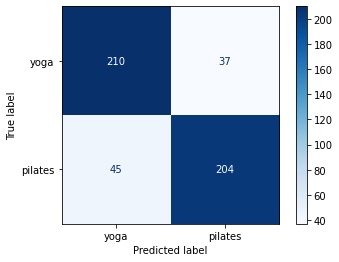

In [33]:
#Print the performance metrics
performance_measures(gs_tvec_lr, X_test, y_test)

In [34]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_tvec_lr = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_tvec_lr.predict_proba(X_test)[:,1]})

pred_tvec_lr.head()

,true_values,pred_probs
1060,1,0.748895
460,0,0.393595
1128,1,0.706460
1102,1,0.760568
683,0,0.362776


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


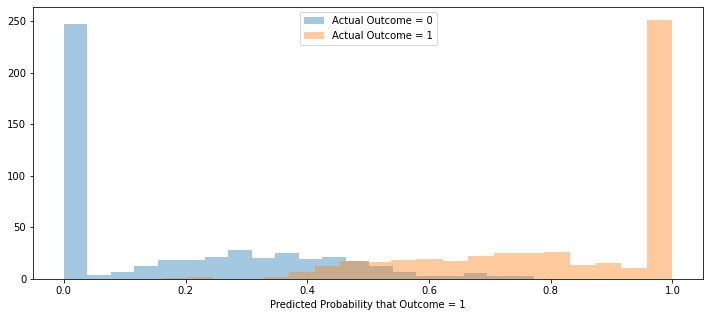

In [35]:
plt.figure(figsize = (12, 5))

#Plot distributions of predicted probabilities by actual values
for group in pred_tvec_lr.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


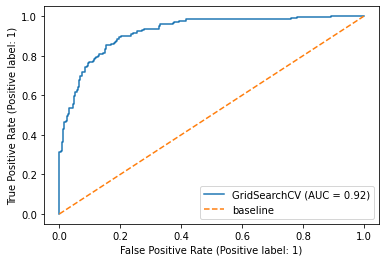

In [36]:
plot_roc_curve(gs_tvec_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [37]:
roc_auc_score(y_test, gs_tvec_lr.predict_proba(X_test)[:,1])

0.9229793668601531

#### Model Pipeline - CountVectorizer & Multinomial Naive Bayes

The Multinomial Naive Bayes algorithm guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance. Naive Bayes classifier is made up of features that are unrelated to any other features.

In [38]:
#Let's set a pipeline up with two stages:
#1. CountVectorizer (transformer)
#2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [39]:
#Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [40]:
# Hyper parameters
#Note that our shape from standard/default CountVectorizer is (1486, 10_000)
pipe_cvec_nb_params = {
    'cvec__max_features': [2_500, 5_000, 10_000], 
    'cvec__min_df': [2, 3], 
    'cvec__max_df': [.85, .9], 
    'cvec__ngram_range': [(1,1), (1,2)], 
}

In [41]:
#Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, 
                          param_grid=pipe_cvec_nb_params, 
                          cv=5,
                          n_jobs=-1) 

In [42]:
#Fit GridSearch to training data.
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [2500, 5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [43]:
#Print the scores and best param
print_score_param(gs_cvec_nb)

======== All Score ========
Best Score: 0.855987164711997
Train Score: 0.9279946164199192
Test Score: 0.8487903225806451

======== Best Params ========
cvec__max_df: 0.85
cvec__max_features: 2500
cvec__min_df: 3
cvec__ngram_range: (1, 2)


======== Performance ========
Accuracy: 0.8488
Specificity: 0.8381
Sensitivity: 0.8594
Precision: 0.8425
F1 score: 0.8509
ROC AUC Score: 0.8487


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


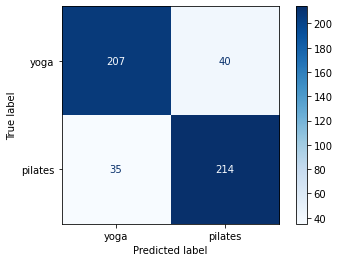

In [44]:
#Print the performance metrics
performance_measures(gs_cvec_nb, X_test, y_test)

In [45]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_cvec_nb = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_cvec_nb.predict_proba(X_test)[:,1]})

pred_cvec_nb.head()

,true_values,pred_probs
1060,1,1.000000
460,0,0.039695
1128,1,0.999976
1102,1,0.999998
683,0,0.027282


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


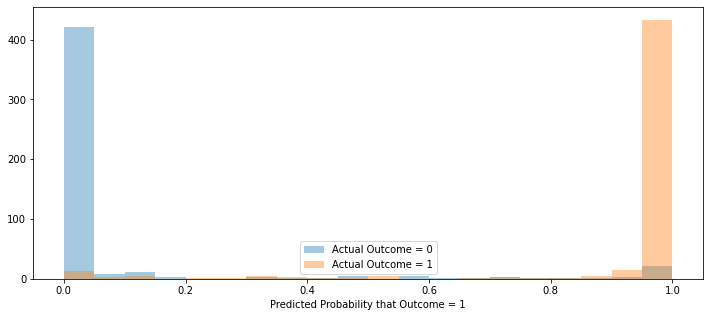

In [46]:
plt.figure(figsize = (12, 5))

#Plot distributions of predicted probabilities by actual values
for group in pred_cvec_nb.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


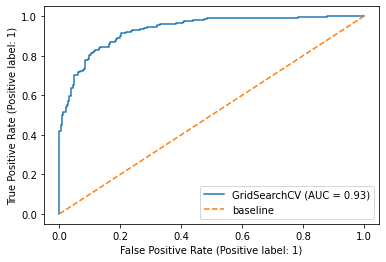

In [47]:
plot_roc_curve(gs_cvec_nb, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [48]:
roc_auc_score(y_test, gs_cvec_nb.predict_proba(X_test)[:,1])

0.9335479570102271

#### Model Pipeline - TfidfVectorizer & Multinomial Naive Bayes

In [49]:
#Let's set a pipeline up with two stages:
#1. TfidfVectorizer (transformer)
#2. Multinomial Naive Bayes (estimator)
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [50]:
#Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify = y)

In [51]:
pipe_tvec_nb_params = {
    'tvec__max_features': [2_500, 5_000, 10_000], 
    'tvec__min_df': [2, 3, 4], 
    'tvec__max_df': [.8, .85, .9], 
    'tvec__ngram_range': [(1,1), (1,2), (2,2)] 
}

In [52]:
#Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, 
                         param_grid = pipe_tvec_nb_params, 
                         cv=5,
                         n_jobs=-1)

In [53]:
#Fit GridSearch to training data.
gs_tvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8, 0.85, 0.9],
                         'tvec__max_features': [2500, 5000, 10000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [54]:
#Print the scores and best param
print_score_param(gs_tvec_nb)

======== All Score ========
Best Score: 0.858683027139403
Train Score: 0.9407806191117093
Test Score: 0.8387096774193549

======== Best Params ========
tvec__max_df: 0.8
tvec__max_features: 2500
tvec__min_df: 3
tvec__ngram_range: (1, 2)


======== Performance ========
Accuracy: 0.8387
Specificity: 0.8259
Sensitivity: 0.8514
Precision: 0.8314
F1 score: 0.8413
ROC AUC Score: 0.8387


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


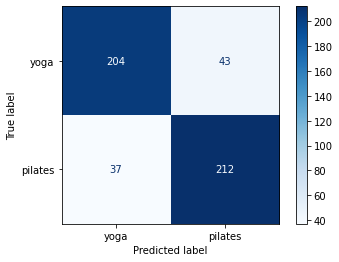

In [55]:
#Print the performance metrics
performance_measures(gs_tvec_nb, X_test, y_test)

In [56]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_tvec_nb = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_tvec_nb.predict_proba(X_test)[:,1]})

pred_tvec_nb.head()

,true_values,pred_probs
1060,1,0.821326
460,0,0.411298
1128,1,0.802990
1102,1,0.804062
683,0,0.368635


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


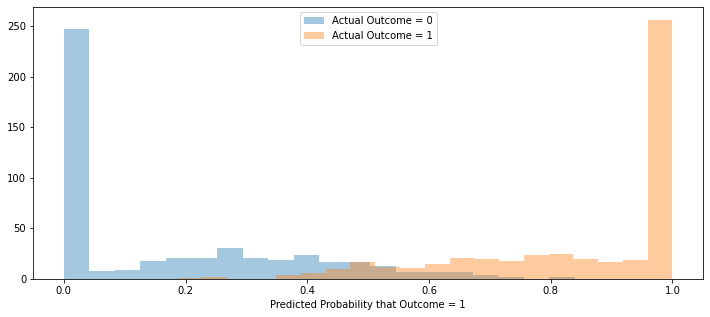

In [57]:
plt.figure(figsize = (12, 5))

#Plot distributions of predicted probabilities by actual values
for group in pred_tvec_nb.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


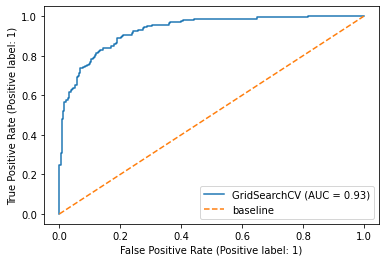

In [58]:
plot_roc_curve(gs_tvec_nb, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [59]:
roc_auc_score(y_test, gs_tvec_nb.predict_proba(X_test)[:,1])

0.9305887517682064

#### Model Pipeline - CountVectorizer & Random Forest

A random forest algorithm consists of many decision trees. The (random forest) algorithm establishes the outcome based on the predictions of the decision trees. It predicts by taking the average or mean of the output from various trees. Increasing the number of trees increases the precision of the outcome. A random forest eradicates the limitations of a decision tree algorithm. It reduces the overfitting of datasets and increases precision.

In [60]:
#Let's set a pipeline up with two stages:
#1. CountVectorizer (transformer)
#2. Random Forest (estimator)

pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

In [61]:
#Hyper parameters
#Note that our shape from standard/default CountVectorizer is (1486, 50_000)
pipe_cvec_rf_params = {
    'rf__n_estimators': [100, 150, 200], #
    "rf__max_depth": [None, 1, 2, 3, 4, 5],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2, 4]
}

In [62]:
#Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [63]:
#Instantiate GridSearchCV.

gs_cvec_rf = GridSearchCV(pipe_cvec_rf, # object for optimizin
                          param_grid=pipe_cvec_rf_params, # parameters values to search
                          cv=5,# 5-fold cross-validation.
                          n_jobs=-1) 

In [64]:
#Fit GridSearch to training data.
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 1, 2, 3, 4, 5],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 150, 200]})

In [65]:
#Print the scores and best param
print_score_param(gs_cvec_rf)

======== All Score ========
Best Score: 0.848582017038393
Train Score: 0.9784656796769852
Test Score: 0.8245967741935484

======== Best Params ========
rf__max_depth: None
rf__min_samples_leaf: 2
rf__min_samples_split: 5
rf__n_estimators: 150


======== Performance ========
Accuracy: 0.8246
Specificity: 0.834
Sensitivity: 0.8153
Precision: 0.832
F1 score: 0.8235
ROC AUC Score: 0.8246


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


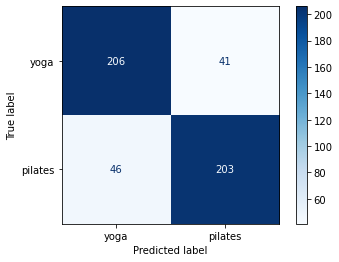

In [66]:
#Print the performance metrics
performance_measures(gs_cvec_rf, X_test, y_test)

In [67]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_cvec_rf = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_cvec_rf.predict_proba(X_test)[:,1]})

pred_cvec_rf.head()

,true_values,pred_probs
1060,1,0.711456
460,0,0.459974
1128,1,0.659388
1102,1,0.658874
683,0,0.377696


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


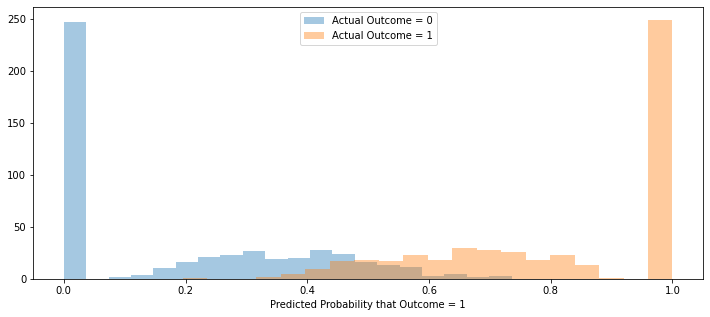

In [68]:
plt.figure(figsize = (12, 5))

#Plot distributions of predicted probabilities by actual values
for group in pred_cvec_rf.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


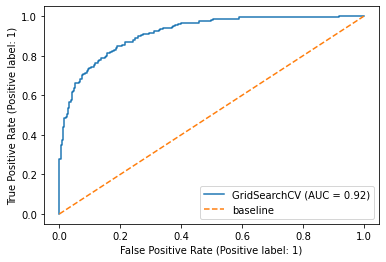

In [69]:
plot_roc_curve(gs_cvec_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [70]:
roc_auc_score(y_test, gs_cvec_rf.predict_proba(X_test)[:,1])

0.9158252442970262

#### Model Pipeline - TfidfVectorizer & Random Forest

In [71]:
#Let's set a pipeline up with two stages:
#1. TfidfVectorizer (transformer)
#2. Random Forest (estimator)
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

In [72]:
#Hyper parameters
pipe_tvec_rf_params = {
    'rf__n_estimators': [100, 150, 200], 
    "rf__max_depth": [None, 1, 2, 3, 4, 5],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2, 4]
}

In [73]:
#Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [74]:
#Instantiate GridSearchCV.
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, 
                         param_grid = pipe_tvec_rf_params, 
                         cv=5,
                         n_jobs=-1)

In [75]:
#Fit GridSearch to training data.
gs_tvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 1, 2, 3, 4, 5],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 150, 200]})

In [76]:
#Print the scores and best param
print_score_param(gs_tvec_rf)

======== All Score ========
Best Score: 0.8378211646668022
Train Score: 0.9549125168236877
Test Score: 0.8104838709677419

======== Best Params ========
rf__max_depth: None
rf__min_samples_leaf: 4
rf__min_samples_split: 2
rf__n_estimators: 200


======== Performance ========
Accuracy: 0.8105
Specificity: 0.8097
Sensitivity: 0.8112
Precision: 0.8112
F1 score: 0.8112
ROC AUC Score: 0.8105


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


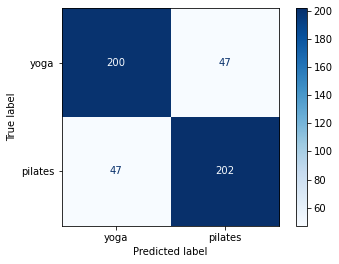

In [77]:
#Print the performance metrics
performance_measures(gs_tvec_rf, X_test, y_test)

In [78]:
#Let's create a dataframe called pred_df that contains:
#1. The list of true values of our test set.
#2. The list of predicted probabilities based on the model.

pred_tvec_rf = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_tvec_rf.predict_proba(X_test)[:,1]})

pred_tvec_rf.head()

,true_values,pred_probs
1060,1,0.681199
460,0,0.433201
1128,1,0.641168
1102,1,0.631740
683,0,0.415726


/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


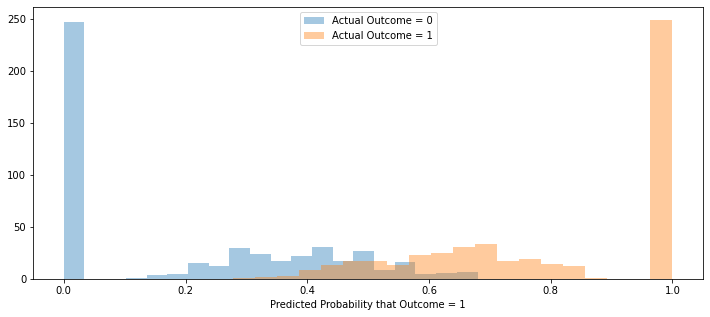

In [79]:
plt.figure(figsize = (12, 5))

#Plot distributions of predicted probabilities by actual values
for group in pred_tvec_rf.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

/Users/twangxh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


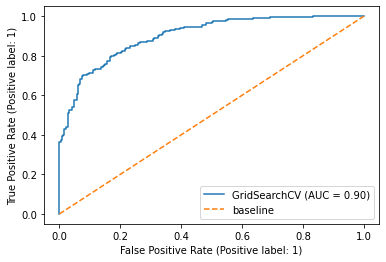

In [80]:
plot_roc_curve(gs_tvec_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [81]:
roc_auc_score(y_test, gs_tvec_rf.predict_proba(X_test)[:,1])

0.9011105149342309

### Conclusion (Summary Table)

| # | **Vectorizer**  | **Model**                 | **Best Score** | **Best Train** | **Test Score (Accuracy)** | **Test Score (Sensitivity)** | **Best Parameters**                                                                        |
|---|-----------------|---------------------------|----------------|----------------|---------------------------|------------------------------|--------------------------------------------------------------------------------------------|
| 1 | CountVectorizer | _Logistic Regression_     | 0.8432         | 0.9993         | 0.8004                    | 0.8032                       | cvec__max_df: 0.85 cvec__max_features: 5000 cvec__min_df: 3 cvec__ngram_range: (1, 2)      |
| 2 | TfidfVectorizer | _Logistic Regression_     | 0.8674         | 0.9549         | 0.8347                    | 0.8193                       | tvec__max_df: 0.8 tvec__max_features: 2500 tvec__min_df: 3 tvec__ngram_range: (1, 2)       |
| 3 | CountVectorizer | _Multinomial Naïve Bayes_ | 0.8560         | 0.9280         | **0.8488**                    | 0.8594                       | cvec__max_df: 0.85 cvec__max_features: 2500 cvec__min_df: 3 cvec__ngram_range: (1, 2)      |
| 4 | TfidfVectorizer | _Multinomial Naïve Bayes_ | 0.8587         | 0.9408         | 0.8387                    | 0.8514                       | tvec__max_df: 0.8 tvec__max_features: 2500 tvec__min_df: 3 tvec__ngram_range: (1, 2)       |
| 5 | CountVectorizer | _Random Forest_           | 0.8486         | 0.9785         | 0.8246                    | 0.8153                       | rf__max_depth: None rf__min_samples_leaf: 2 rf__min_samples_split: 5 rf__n_estimators: 150 |
| 6 | TfidfVectorizer | _Random Forest_           | 0.8378         | 0.9549         | 0.8105                    | 0.8112                       | rf__max_depth: None rf__min_samples_leaf: 4 rf__min_samples_split: 2 rf__n_estimators: 200 |

##### Model Selection: Multinomial Naïve Bayes with Count Vectorizer

### Business Recommendations

Our baseline accuracy score is 0.503 and every model have outperformed it. In order to increase our awareness for pilates, our marketing efforts must be able to differentiate between yoga and pilates. Hence, the focus is on getting as many correct predictions as possible. The Multinomial Naïve Bayes with CountVectorizer has the best predictive performance on the classification problem. Through the research we were able to address some other problems such as identifying the top common words and even performed sentiment analysis. The marketing team and the stakeholders would then be able to perform a more data-driven approach in handling the marketing campaigns for pilates.

### Further Analysis

For future steps, we can analyse pilates with other exercises offered by ClassPass. As yoga and pilates are similar, the scores attained were all 0.8 (in terms of accuracy). Hence, should try to compare pilates with exercises that is not yoga to see whether will the models perform better.

We can also understand more on the trend of pilates over the years more in-depth so as to understand what are the features of pilates that attracts people to start learning and practicing it. Once we have such informations, we would be able to further improve our awareness campaigns.

References:

https://www.bodyandsoul.com.au/fitness/training-tips/why-is-pilates-everywhere-now-and-what-did-covid-have-to-do-with-it/news-story/49ece150142fad14048bdb6608b44581

Fitness and beauty trends 2021. (2021, July 28). ClassPass Blog. https://classpass.com/blog/2021-comeback-fitness-trends/

The key differences between yoga and Pilates. (2021, March 16). Harper's BAZAAR. https://www.harpersbazaar.com/uk/beauty/fitness-wellbeing/a25626354/yoga-vs-pilates/